In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np

In [8]:
cd drive/My\ Drive/Neural_Machine_Translation

/content/drive/My Drive/Neural_Machine_Translation


In [5]:
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
import pandas as pd 
data = "/content/drive/MyDrive/Neural_Machine_Translation/deu.txt"

In [7]:
file = open("/content/drive/MyDrive/Neural_Machine_Translation/deu.txt","r")

In [9]:
text=file.read()

In [10]:
text[0:200]

'Go.\tGeh.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)\nHi.\tHallo!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)\nHi.\tGrüß Gott!\tCC-BY 2.0'

In [11]:
uncleaned_data_list = text.split('\n')
len(uncleaned_data_list)
uncleaned_data_list = uncleaned_data_list[:50000]
len(uncleaned_data_list)

english_word=[]
german_word=[]
cleaned_data_list=[]
for word in uncleaned_data_list:
  english_word.append(word.split('\t')[:-1][0])
  german_word.append(word.split('\t')[:-1][1])

language_data = pd.DataFrame(columns=["English","German"])
language_data["English"] = english_word
language_data["German"] = german_word

language_data.to_csv('language_data.csv',index=False)

In [12]:
language_data.head()

,English,German
0,Go.,Geh.
1,Hi.,Hallo!
2,Hi.,Grüß Gott!
3,Run!,Lauf!
4,Run.,Lauf!


In [13]:
english_text=language_data["English"].values
german_text=language_data["German"].values

In [14]:
english_text

array(['Go.', 'Hi.', 'Hi.', ..., "I'm giving up smoking.",
       "I'm glad I was nearby.", "I'm glad Tom has gone."], dtype=object)

In [15]:
def cleanDocs(lines):
  clean=[]
  lines = [x.lower() for x in lines]
  lines = [re.sub("'",'',x) for x in lines]
  for sent in lines:
    lines = [word.translate(str.maketrans('', '', string.punctuation)) for word in sent.split(' ')]
    lines = [word for word in lines if word.isalpha()]
    clean.append(' '.join(lines))
  return clean




In [16]:
english_text_ = cleanDocs(english_text)
german_text_=cleanDocs(german_text)

In [17]:
german_text_

['geh',
 'hallo',
 'grüß gott',
 'lauf',
 'lauf',
 'potzdonner',
 'donnerwetter',
 'feuer',
 'hilfe',
 'zu hülf',
 'stopp',
 'anhalten',
 'warte',
 'warte',
 'fang an',
 'mach weiter',
 'hallo',
 'sers',
 'beeil dich',
 'schnell',
 'ich versteckte mich',
 'ich habe mich versteckt',
 'ich rannte',
 'ich verstehe',
 'aha',
 'ich probiere es',
 'ich hab gewonnen',
 'ich habe gewonnen',
 'entspann dich',
 'feuer',
 'schieß',
 'lächeln',
 'frag mich',
 'fragt mich',
 'fragen sie mich',
 'angriff',
 'attacke',
 'zum wohl',
 'iss es',
 'iss auf',
 'iss auf',
 'keine bewegung',
 'stehenbleiben',
 'geh jetzt',
 'verstanden',
 'ich',
 'aha',
 'kapiert',
 'verstanden',
 'einverstanden',
 'er rannte',
 'er lief',
 'mach mit',
 'spring rein',
 'drück mich',
 'nimm mich in den arm',
 'umarme mich',
 'mir ist es wichtig',
 'ich fiel',
 'ich fiel hin',
 'ich stürzte',
 'ich bin hingefallen',
 'ich bin gestürzt',
 'ich flüchtete',
 'ich bin geflüchtet',
 'ich weiß',
 'ich habe gelogen',
 'ich habe verl

In [18]:
english_text_

['go',
 'hi',
 'hi',
 'run',
 'run',
 'wow',
 'wow',
 'fire',
 'help',
 'help',
 'stop',
 'stop',
 'wait',
 'wait',
 'begin',
 'go on',
 'hello',
 'hello',
 'hurry',
 'hurry',
 'i hid',
 'i hid',
 'i ran',
 'i see',
 'i see',
 'i try',
 'i won',
 'i won',
 'relax',
 'shoot',
 'shoot',
 'smile',
 'ask me',
 'ask me',
 'ask me',
 'attack',
 'attack',
 'cheers',
 'eat it',
 'eat up',
 'eat up',
 'freeze',
 'freeze',
 'go now',
 'got it',
 'got it',
 'got it',
 'got it',
 'got it',
 'got it',
 'he ran',
 'he ran',
 'hop in',
 'hop in',
 'hug me',
 'hug me',
 'hug me',
 'i care',
 'i fell',
 'i fell',
 'i fell',
 'i fell',
 'i fell',
 'i fled',
 'i fled',
 'i know',
 'i lied',
 'i lost',
 'i paid',
 'i paid',
 'i sang',
 'i spit',
 'i spit',
 'i swim',
 'i wept',
 'i wept',
 'im',
 'im',
 'im ok',
 'im ok',
 'im up',
 'im up',
 'listen',
 'no way',
 'no way',
 'no way',
 'no way',
 'no way',
 'really',
 'really',
 'really',
 'thanks',
 'try it',
 'we try',
 'we won',
 'why me',
 'ask tom',


In [19]:
def split(lines):
  lines = [x.strip() for x in lines]
  return lines

In [20]:
english_text_=split(english_text_)
german_text_=split(german_text_)

In [21]:
# Putting the start and end words in the english sentances
english_text_ = ["start " + x + " end" for x in english_text_]
# manipulated_english_text_
german_text_[0], english_text_[0]

('geh', 'start go end')

In [22]:
X = german_text_
Y = english_text_
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.1)

In [23]:
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_
#Training data
max_length_english = Max_length(y_train)
max_length_german = Max_length(X_train)
#Test data
max_length_english_test = Max_length(y_test)
max_length_german_test = Max_length(X_test)
max_length_german, max_length_english

(15, 8)

In [24]:
with open('max_length_english.pkl','wb') as f:
  pkl.dump(max_length_english, f)

In [25]:
with open('max_length_german.pkl','wb') as f:
  pkl.dump(max_length_german, f)

In [26]:
# Instantiating the tokenizer class
def createTokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
englishTokenizer = createTokenizer(y_train)
germanTokenizer = createTokenizer(X_train)


In [27]:
with open('englishTokenizer.pkl','wb') as f:
  pkl.dump(englishTokenizer, f)

In [28]:
with open('germanTokenizer.pkl','wb') as f:
  pkl.dump(germanTokenizer, f)

In [29]:
list(englishTokenizer.word_index.items())[0:10]

[('start', 1),
 ('end', 2),
 ('tom', 3),
 ('i', 4),
 ('you', 5),
 ('is', 6),
 ('a', 7),
 ('it', 8),
 ('the', 9),
 ('to', 10)]

In [30]:
list(germanTokenizer.word_index.items())[0:10]

[('ich', 1),
 ('tom', 2),
 ('ist', 3),
 ('das', 4),
 ('sie', 5),
 ('nicht', 6),
 ('es', 7),
 ('du', 8),
 ('er', 9),
 ('hat', 10)]

In [31]:
Eword2index = englishTokenizer.word_index
Gword2index = germanTokenizer.word_index


In [32]:
with open('Eword2index.pkl','wb') as f:
  pkl.dump(Eword2index, f)

In [33]:
with open('Gword2index.pkl','wb') as f:
  pkl.dump(Gword2index, f)

In [37]:
#Vocab size of source and target

vocab_size_source = len(germanTokenizer.word_index) + 1
vocab_size_target = len(englishTokenizer.word_index) + 1


In [38]:
vocab_size_source, vocab_size_target

(9705, 5969)

In [39]:
with open('vocab_size_source.pkl','wb') as f:
  pkl.dump(vocab_size_source, f)

In [40]:
with open('vocab_size_target.pkl','wb') as f:
  pkl.dump(vocab_size_target, f)

In [41]:
# Function for encoding and padding sequences
 
def encode_sequences(tokenizer,length, lines):
    # Sequences as integers
    X = tokenizer.texts_to_sequences(lines)
    # Padding the sentences with 0
    X = pad_sequences(X,maxlen=length,padding='post')
    return X

In [42]:
X_train = encode_sequences(germanTokenizer, max_length_german, X_train)
X_test = encode_sequences(germanTokenizer, max_length_german, X_test)
y_train = encode_sequences(englishTokenizer, max_length_english, y_train)
y_test = encode_sequences(englishTokenizer, max_length_english, y_test)


In [46]:
X_train[0],y_train[0]

(array([  1,  14, 962,  37,   5,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0], dtype=int32),
 array([ 1, 12, 32, 71, 75, 89,  2,  0,  0], dtype=int32))

In [47]:
def converting_to_array(lines):
  lines = np.array(lines)
  return lines


In [48]:
X_train = converting_to_array(X_train)
X_test = converting_to_array(X_test)
y_train = converting_to_array(y_train)
y_test = converting_to_array(y_test)

In [49]:
with open('X_test.pkl','wb') as f:
  pkl.dump(X_test, f)

In [50]:
with open('y_test.pkl','wb') as f:
  pkl.dump(y_test, f)

In [51]:
from attention import AttentionLayer
from keras import backend as K 
K.clear_session() 

def defineModel(latent_dim,max_length_source,src_vocab,trg_vocab):  
  # Encoder 
  encoder_inputs = Input(shape=(max_length_source,)) 
  enc_emb = Embedding(src_vocab, latent_dim,trainable=True)(encoder_inputs)
  #LSTM 1 
  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
  #LSTM 2 
  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
  #LSTM 3 
  encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
  # Set up the decoder. 
  decoder_inputs = Input(shape=(None,)) 
  dec_emb_layer = Embedding(trg_vocab, latent_dim,trainable=True) 
  dec_emb = dec_emb_layer(decoder_inputs)
  #LSTM using encoder_states as initial state
  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
  #Attention Layer
  attn_layer = AttentionLayer(name='attention_layer') 
  attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
  # Concat attention output and decoder LSTM output 
  decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
  #Dense layer
  decoder_dense = TimeDistributed(Dense(trg_vocab, activation='softmax')) 
  decoder_outputs = decoder_dense(decoder_concat_input)
  # Define the model
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
  return model



In [52]:
model=defineModel(500,max_length_german,vocab_size_source,vocab_size_target)

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 500)      4852500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 15, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

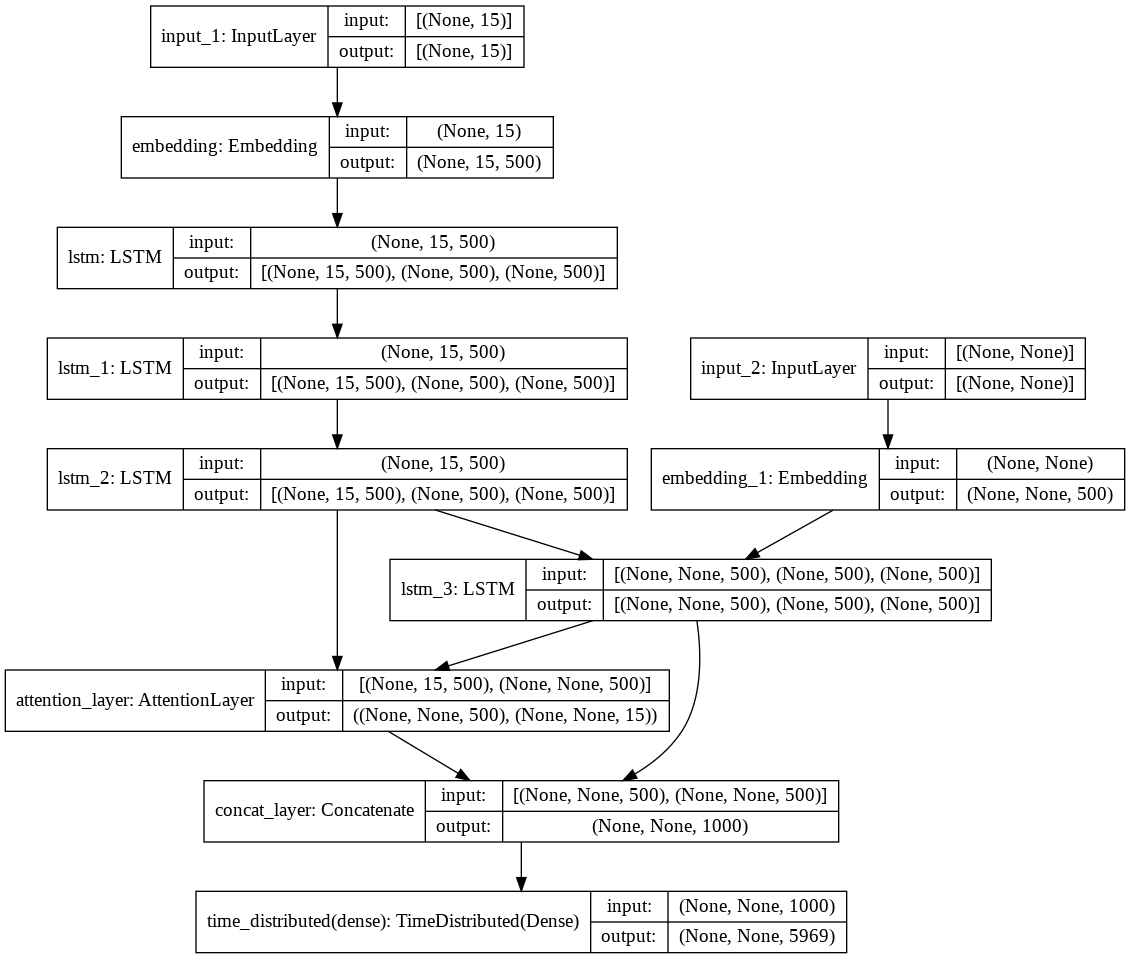

In [54]:
plot_model(model, to_file='train_model.png', show_shapes=True)

In [55]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [56]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [57]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:], 
                    epochs=15, 
                    callbacks=[es],
                    batch_size=100,
                    validation_data = ([X_test, y_test[:,:-1]],y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/15
450/450 [==============================] - 1272s 3s/step - loss: 2.9356 - accuracy: 0.5582 - val_loss: 1.9571 - val_accuracy: 0.6701
Epoch 2/15
450/450 [==============================] - 1262s 3s/step - loss: 1.8687 - accuracy: 0.6834 - val_loss: 1.6294 - val_accuracy: 0.7203
Epoch 3/15
450/450 [==============================] - 1267s 3s/step - loss: 1.5300 - accuracy: 0.7328 - val_loss: 1.4384 - val_accuracy: 0.7491
Epoch 4/15
450/450 [==============================] - 1270s 3s/step - loss: 1.3087 - accuracy: 0.7636 - val_loss: 1.3205 - val_accuracy: 0.7661
Epoch 5/15
450/450 [==============================] - 1272s 3s/step - loss: 1.1354 - accuracy: 0.7910 - val_loss: 1.2071 - val_accuracy: 0.7845
Epoch 6/15
450/450 [==============================] - 1273s 3s/step - loss: 0.9879 - accuracy: 0.8153 - val_loss: 1.1374 - val_accuracy: 0.7954
Epoch 7/15
450/450 [==============================] - 1276s 3s/step - loss: 0.8633 - accuracy: 0.8373 - val_loss: 1.0839 - val_accuracy:

In [75]:
model.save('model.h5')
#model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [73]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [74]:
json_file = open("NMT_model.json",'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer':AttentionLayer})
model_loaded.load_weights("NMT_model_weight.h5")

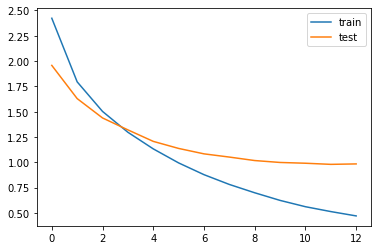

In [65]:
from matplotlib import pyplot
pyplot.plot(history.history["loss"],label="train")
pyplot.plot(history.history["val_loss"],label="test")
pyplot.legend()
pyplot.show()

In [34]:
Eindex2word = englishTokenizer.index_word
Gindex2word = germanTokenizer.index_word

In [35]:
with open('Eindex2word.pkl','wb') as f:
  pkl.dump(Eindex2word, f)

In [36]:
with open('Gindex2word.pkl','wb') as f:
  pkl.dump(Gindex2word, f)

In [67]:
latent_dim=500
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs

print(encoder_outputs.shape)

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(15,latent_dim))

# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output

print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]

dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

(None, 15, 500)
(None, None)


In [68]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Eword2index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
          sampled_token = Eindex2word[sampled_token_index]

          if(sampled_token!='end'):
              decoded_sentence += ' '+sampled_token

              # Exit condition: either hit max length or find stop word.
              if (sampled_token == 'end' or len(decoded_sentence.split()) >= (9-1)):
                  stop_condition = True

          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index

          # Update internal states
          e_h, e_c = h, c

    return decoded_sentence

In [69]:
Eindex2word = englishTokenizer.index_word
Gindex2word = germanTokenizer.index_word

In [70]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Eword2index['start']) and i!=Eword2index['end']):
        newString=newString+Eindex2word[i]+' '
    return newString
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Gindex2word[i]+' '
    return newString

In [71]:
for i in range(10):  
  print("Review:",seq2text(X_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",decode_sequence(X_test[i].reshape(1,15)))
  print("\n")

Review: hat tom hunger 
Original summary: is tom hungry 
Predicted summary:  is tom hungry


Review: der server ist ausgefallen 
Original summary: the server is down 
Predicted summary:  the street is closed


Review: tom hat dort gearbeitet 
Original summary: tom worked there 
Predicted summary:  tom worked there


Review: rauchen sie viel 
Original summary: do you smoke a lot 
Predicted summary:  do you smoke a lot


Review: tom sah entsetzt aus 
Original summary: tom looked appalled 
Predicted summary:  tom looked pale


Review: du solltest mehr essen 
Original summary: you should eat more 
Predicted summary:  you should eat more


Review: mir kommt das komisch vor 
Original summary: i think its strange 
Predicted summary:  my mind is that


Review: ich bin schon reich 
Original summary: im already rich 
Predicted summary:  im too old


Review: ich will bares 
Original summary: i want cash 
Predicted summary:  i want to play golf


Review: tom wirkt launisch 
Original summary: tom s